# Pose Detection with AlphaPhose v0.3.0

This notebook uses an open source project [MVIG-SJTU/AlphaPose](https://github.com/MVIG-SJTU/AlphaPose) to detect/track multi person poses on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install AlphaPose v0.3.0

In [0]:
!pip install -U torch==1.4 torchvision==0.5 -f https://download.pytorch.org/whl/cu101/torch_stable.html
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/MVIG-SJTU/AlphaPose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # clone and install dependencies
  !git clone -q {git_repo_url}
  !pip install -q youtube-dl cython gdown
  !pip install -q -U PyYAML
  !apt-get install -y -q libyaml-dev
  !cd {project_name} && git checkout 7be9809 && python setup.py build develop --user
  
import sys
sys.path.append(project_name)
import time
import matplotlib
import matplotlib.pylab as plt
plt.rcParams["axes.grid"] = False

from IPython.display import YouTubeVideo

## Download pretrained models

In [0]:
yolo_pretrained_model_path = join(project_name, 'detector/yolo/data/yolov3-spp.weights')
if not exists(yolo_pretrained_model_path):
  # download the YOLO weights
  !mkdir -p {project_name}/detector/yolo/data
  !gdown -O {yolo_pretrained_model_path} https://drive.google.com/uc?id=1D47msNOOiJKvPOXlnpyzdKA3k6E97NTC

#tracker_pretrained_model_path = join(project_name, 'detector/tracker/data/jde.1088x608.uncertainty.pt')
#if not exists(tracker_pretrained_model_path):
#  # tracker weights
#  !mkdir -p {project_name}/detector/tracker/data
#  !gdown -O {tracker_pretrained_model_path} https://drive.google.com/uc?id=1nlnuYfGNuHWZztQHXwVZSL_FvfE551pA

# ResNet152 backbone 73.3 AP
pretrained_model_path = join(project_name, 'pretrained_models/fast_421_res152_256x192.pth')
pretrained_model_config_path = join(project_name, 'configs/coco/resnet/256x192_res152_lr1e-3_1x-duc.yaml')
if not exists(pretrained_model_path):
  # download the pretrained model
  !gdown -O {pretrained_model_path} https://drive.google.com/uc?id=1kfyedqyn8exjbbNmYq8XGd2EooQjPtF9

## Detect poses on a test video

We are going to detect poses on the following youtube video:

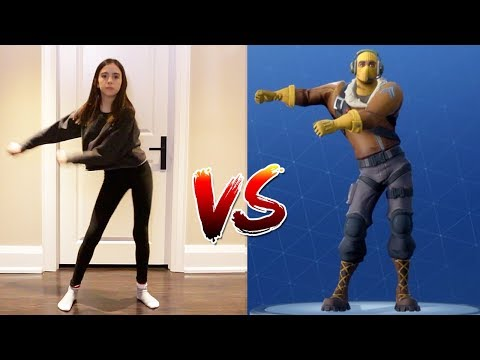

In [3]:
YOUTUBE_ID = 'RXABo9hm8B8'


YouTubeVideo(YOUTUBE_ID)

Download the above youtube video, cut the first 5 seconds and do the pose detection on that 5 seconds:

In [0]:
!rm -df youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v={YOUTUBE_ID}
# cut the first 5 seconds
!ffmpeg -y -loglevel info -i youtube.mp4 -t 5 video.avi
# run AlpaPose on these 5 seconds video
!rm -rf AlphaPose_video.avi
!cd {project_name} && python3 scripts/demo_inference.py --sp --video ../video.avi --outdir ../ --save_video --checkpoint ../{pretrained_model_path} --cfg ../{pretrained_model_config_path}
# convert the result into MP4
!ffmpeg -y -loglevel info -i AlphaPose_video.avi -vcodec libx264 AlphaPose_video.mp4

Finally, visualize the result:

In [0]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('AlphaPose_video.mp4', width=960, height=720)